## Lab 7: Isentropic Analysis
In this week's lab, we will use archived GFS model data to create our first isentropic analyses with MetPy's help.  We will also create QG forcing maps for comparison.

<br />


### Useful Documentation
1. Xarray open_dataset:  https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html
2. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
3. Matplotlib Quiver: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html
4. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
5. MetPy Units: https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html
6. Datetime: https://docs.python.org/3/library/datetime.html
7. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
8. MetPy Q-Vector: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.q_vector.html
9. MetPy mixing_ratio_from_specific_humidity: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.mixing_ratio_from_specific_humidity.html
10. MetPy isentropic_interpolation_as_dataset: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.isentropic_interpolation_as_dataset.html#metpy.calc.isentropic_interpolation_as_dataset



<br />

## Tutorial

In this week's lab, the vertical coordinate system changes from pressure (isobaric) to potential temperature (isentropic).  The GFS archived data are stored with pressure or sigma (a terrain-following coordinate that we are not using) as the vertical coordinate, however.  Thus, to make this week's maps, we need to use MetPy's isentropic interpolation function to convert the GFS data to the isentropic vertical coordinate.

<br />

1. First, we open a sample dataset, here representing a GFS analysis from February 9th, 2023.

In [1]:
from datetime import datetime
import xarray as xr

time = datetime(2023,2,9,0)
data_location = "/data/AtmSci360/Synp2/Lab_7/"
file_name = f"{time:%m%d%y_%H}_gfs.grib2"

data = xr.open_dataset(f"{data_location}{file_name}", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
data

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 609, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33, latitude: 721, longitude: 1440)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
    q              (isobaricInhPa, latitude, longitude) float32 ...
    w              (isobaricInhPa, latitude, longitude) float32 ...
    wz             (isobaricInhPa, latitude, longitude) float32 ...
    u              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    absv           (isobaricInhPa, latitude, longitude) float32 ...
    o3mr           (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2023-04-16T13:44 GRIB to CDM+CF via cfgrib-0.9.1...

<br />

2. Next, we define the desired levels for the isentropic analysis or analyses.  In the example below, we consider only the 300-K isentropic level.  The MetPy function can do multiple levels at once, however; to add a level, simply add its value to the list below.  Note that MetPy requires this list of levels to have units.

In [2]:
from metpy.units import units
levels = [300] * units.kelvin
levels

array([300]) <Unit('kelvin')>

<br />

3. Now we are ready to use MetPy's isentropic_interpolation_as_dataset.  This function requires multiple arguments:
<ul>
    <li>The isentropic level or levels to which the data should be interpolated.</li>
    <li>The model data's temperature variable.</li>
    <li>The model data's variable or variables to which you want to interpolate to the isentropic surface.</li>
</ul>

In this example, four variables would be interpolated to the isentropic surface: u, v, r (relative humidity), and q (specific humidity).  The function returns an xarray dataset that is similar to the original, except with a vertical coordinate of isentropic_level rather than isobaricInhPa.  From here, you can work with the data as before.

In [3]:
import metpy.calc as calc
calc.isentropic_interpolation_as_dataset(levels, data.t, data.u, data.v, data.r, data.q)

/opt/tljh/user/lib/python3.7/site-packages/metpy/xarray.py:354: UserWarning: More than one time coordinate present for variable "t".
  + varname + '.')
/opt/tljh/user/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


<xarray.Dataset>
Dimensions:           (isentropic_level: 1, latitude: 721, longitude: 1440)
Coordinates:
  * isentropic_level  (isentropic_level) int64 300
    step              timedelta64[ns] 00:00:00
    valid_time        datetime64[ns] 2023-02-09
    time              datetime64[ns] 2023-02-09
  * latitude          (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude         (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
Data variables:
    pressure          (isentropic_level, latitude, longitude) float64 <Quanti...
    temperature       (isentropic_level, latitude, longitude) float64 <Quanti...
    u                 (isentropic_level, latitude, longitude) float64 <Quanti...
    v                 (isentropic_level, latitude, longitude) float64 <Quanti...
    r                 (isentropic_level, latitude, longitude) float64 <Quanti...
    q                 (isentropic_level, latitude, longitude) float64 <Quanti...

<br />

### Instructions
So that you can complete this week's lab, I have locally archived the January 3rd, 2023 0000 UTC GFS analysis.  The location of these data is provided for you below, as is the filename convention if you wish to use a datetime object to select your time of interest.

Create the following maps for January 3rd, 2023 at 0000 UTC:

<ul>
  <li>300 K pressure, mixing ratio, and wind barbs
  <li>925 hPa geopotential height, temperature, and wind barbs
  <li>850 hPa geopotential height, temperature, and wind barbs
  <li>700 hPa geopotential height, temperature, and wind barbs
  <li>700 hPa Q-Vectors and Q-Vector Divergence
</ul>

For the 300 K mixing ratio, first compute the specific humidity on the isentropic surface and then use the MetPy mixing_ratio_from_specific_humidity function to calculate mixing ratio.  Be sure to convert mixing ratio from kg/kg to g/kg.  Finally, be sure your maps follow the "good map" guidelines, and do not forget to import the necessary packages before you start coding.  

In [4]:
from datetime import datetime
from metpy.io import add_station_lat_lon
from metpy.plots import StationPlot, sky_cover
import numpy as np
import cartopy.crs as crs 
import cartopy
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import xarray as xr
from siphon.simplewebservice.iastate import IAStateUpperAir
import sys
from metpy.units import units
import metpy.calc as calc
import pandas as pd

In [5]:
'''
# variable to specify datetime
time = 

# location of the data
data_location = "/data/AtmSci360/Synp2/Lab_7/"

# naming convention for the GFS data files (if you want to use datetime)
file_name = f"{time:%m%d%y_%H}_gfs.grib2"
'''

'\n# variable to specify datetime\ntime = \n\n# location of the data\ndata_location = "/data/AtmSci360/Synp2/Lab_7/"\n\n# naming convention for the GFS data files (if you want to use datetime)\nfile_name = f"{time:%m%d%y_%H}_gfs.grib2"\n'

In [6]:
def process_K_air_data(time):
    data_location = "/data/AtmSci360/Synp2/Lab_7/"

    file_name = f"{time:%m%d%y_%H}_gfs.grib2"
  
    model_data = xr.open_dataset(f"{data_location}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    levels = [300] * units.kelvin
    Kdata=calc.isentropic_interpolation_as_dataset(levels, model_data.t, model_data.u, model_data.v, model_data.r, model_data.q)
    return Kdata

In [7]:
def process_upper_air_data(time):
    data_location = "/data/AtmSci360/Synp2/Lab_7/"

    file_name = f"{time:%m%d%y_%H}_gfs.grib2"
    model_data = xr.open_dataset(f"{data_location}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})


   
    
    return model_data

In [8]:
def plot_300K(time, Kdata):
    model_data=Kdata.sel(isentropic_level=300)
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
 
    fig = plt.figure(figsize=(11.5,7),dpi=300)
    ax=plt.subplot(projection = proj)

    
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    ax.add_feature(cartopy.feature.BORDERS)
    
    
   
    ax.set_extent((-125, -65, 23, 60))
    
  
    smooth_heights = gaussian_filter(model_data["pressure"].values,2)
    
   
    cont_h = plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,1100,30),linewidths = 0.5,colors='k', transform=crs.PlateCarree())
    
    
    ax.clabel(cont_h, cont_h.levels, fmt=lambda v: format(v, '.0f'),fontsize=8)
    MR=calc.mixing_ratio_from_specific_humidity(model_data.q)
    MR=MR.values*1000
    smooth_MR = gaussian_filter(MR,2)
    

    cont = plt.contourf(model_data["longitude"].values, model_data["latitude"].values,smooth_MR,np.arange(0.4,24,3), cmap='Greens', transform=crs.PlateCarree(), zorder=1, alpha=0.6)
           
    
    cbar = plt.colorbar(cont)
    cbar.set_label(("Mixing Ratio g/kg"), size=10, weight="bold")
    
    wind_slice_x = slice(None, None, 14)
    wind_slice_y = slice(None, None, 14)
    
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    
    
    
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=7, loc="right")         
    plt.title(" 300K, Pressure (black| hpa), Mixing Ratio (filled| g/kg), Wind Speed (barbs|kt)",size=7,weight="bold",loc="left")            
    

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 609, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        

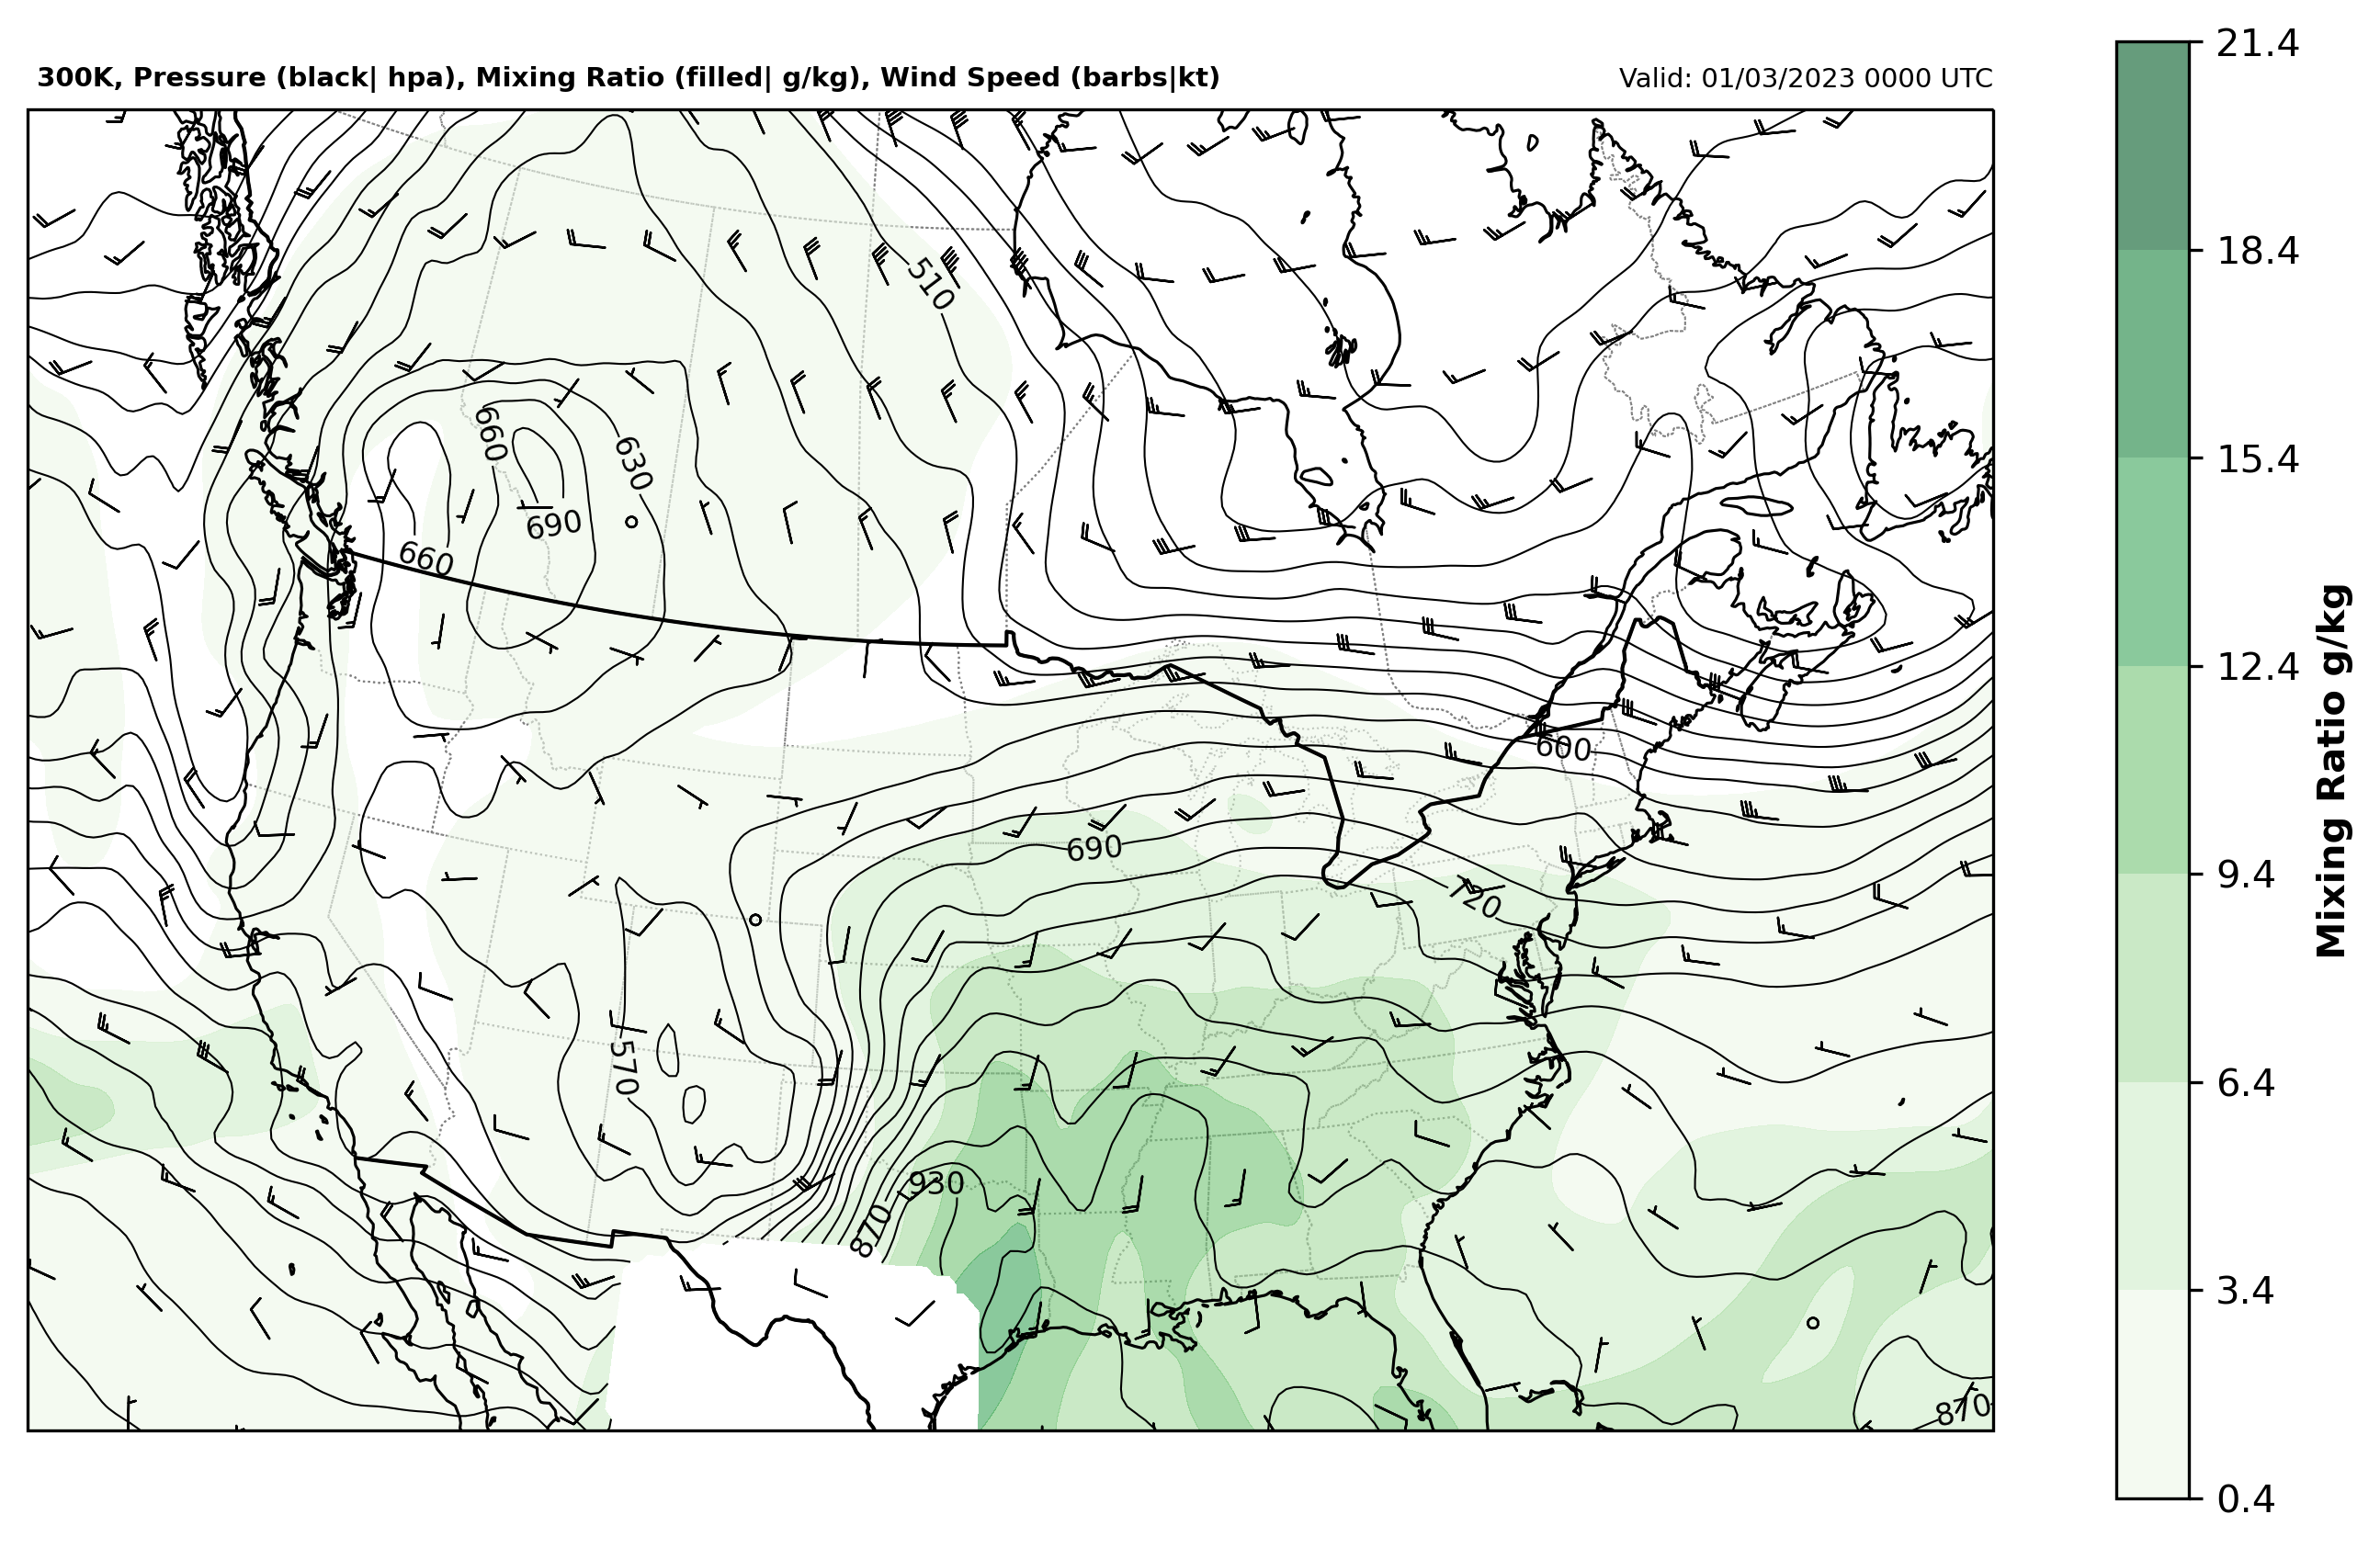

In [9]:
time=datetime(2023,1,3,0)
Kdata=process_K_air_data(time)
plot_300K(time, Kdata)

In [10]:
def plot_700_map(time,model_data):
    model_data=model_data.sel(isobaricInhPa=700)
   
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
    fig = plt.figure(figsize=(11,85),dpi=300)
    
    ax = plt.subplot(projection = proj)
    
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)

    
    ax.set_extent((-125, -65, 23, 60))

    
    model_data['t'].values = gaussian_filter(model_data['t'].values,3)
    model_data['u'].values = gaussian_filter(model_data['u'].values,3)
    model_data['v'].values = gaussian_filter(model_data['v'].values,3)
    
    q_u, q_v = calc.q_vector( model_data['u'], model_data['v'], model_data['t'], model_data['isobaricInhPa'])
    divergence = calc.divergence(q_u, q_v)
    contq = ax.contourf(model_data['longitude'].values, model_data['latitude'].values, divergence.values* 10**17, np.arange(-15,15,2), cmap="bwr_r", transform=crs.PlateCarree(), extend="both", alpha=0.75)

    cb = plt.colorbar(contq,shrink=0.10)
    cb.set_label(("Q-Vector Divergence $m kg^{-1} s^{-1}$ x $10^{-17}$"), size=9)
    
    spacing = slice(None, None, 4)

    ax.quiver(model_data['longitude'].values[spacing],
          model_data['latitude'].values[spacing],
          q_u.values[spacing, spacing],
          q_v.values[spacing, spacing],
          transform=crs.PlateCarree(),
          scale=3 * 10**-10)
    
    
    model_data['t'] = model_data["t"].metpy.convert_units('degC')
    model_data['u'] = model_data["u"].metpy.convert_units('kt')
    model_data['v'] = model_data["v"].metpy.convert_units('kt')
    
    
    filtered_gh = gaussian_filter(model_data["gh"].values,2)

    cont = plt.contour(model_data["longitude"].values, model_data["latitude"].values, filtered_gh, np.arange(0,12000,30), linewidths = 0.7, colors='k', transform=crs.PlateCarree())
    
 
    ax.clabel(cont, cont.levels, inline=True, fmt=lambda v: format(v, '.0f')[:3], fontsize=6)
    
    filtered_temp = gaussian_filter(model_data["t"].values, 2)
  
    cont_t = plt.contour(model_data["longitude"].values, model_data["latitude"].values, filtered_temp, np.arange(-30,38,3), colors='r', linewidths=0.5, linestyles="solid", transform=crs.PlateCarree(), alpha=0.6, zorder=1)

    ax.clabel(cont_t, cont_t.levels, inline=True, fmt=lambda v: format(v, '.0f'), fontsize=6)
    
    wind_slice_x = slice(None, None, 14)
    wind_slice_y = slice(None, None, 14)
    
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    

 
    plt.title("700 hpa Q-Vectors and Q-Vector Divergence ($m kg^{-1} s^{-1}$ x $10^{-17}$), Geopotential Height (black| dm), Temperature (red | $\degree$C), Wind Speed (barbs|kt)", size=4, weight="bold", loc="left")
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=7, loc="right")
   
    plt.show()

In [11]:
def plot_850_map(time, model_data):
    model_data=model_data.sel(isobaricInhPa=850)
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
 
    fig = plt.figure(figsize=(11.5,7),dpi=300)
    ax=plt.subplot(projection = proj)

    
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    ax.add_feature(cartopy.feature.BORDERS)
    
    
   
    ax.set_extent((-125, -65, 23, 60))
    
  
    smooth_heights = gaussian_filter(model_data["gh"].values,2)
    
   
    cont_h = plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,10000,30),linewidths = 0.5,colors='k', transform=crs.PlateCarree())
    
    

    ax.clabel(cont_h, cont_h.levels, fmt=lambda v: format(v, '.0f'),fontsize=8)

    model_data['t'] = model_data["t"].metpy.convert_units('degC')
    model_data['u'] = model_data["u"].metpy.convert_units('kt')
    model_data['v'] = model_data["v"].metpy.convert_units('kt')
    
    filtered_temp = gaussian_filter(model_data["t"].values, 2)
  
    cont_t = plt.contour(model_data["longitude"].values, model_data["latitude"].values, filtered_temp, np.arange(-30,38,3), colors='r', linewidths=0.5, linestyles="solid", transform=crs.PlateCarree(), alpha=0.6, zorder=1)

    ax.clabel(cont_t, cont_t.levels, inline=True, fmt=lambda v: format(v, '.0f'), fontsize=6)
    
    
    
    wind_slice_x = slice(None, None, 14)
    wind_slice_y = slice(None, None, 14)
    
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    

    
    
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=7, loc="right")         
    plt.title("850 hpa Geopotential Height (black| dm),Temperature(red|$\degree$C), Wind Speed (barbs|kt)",size=7,weight="bold",loc="left")            
    

In [12]:
def plot_925_map(time, model_data):
    model_data=model_data.sel(isobaricInhPa=925)
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
 
    fig = plt.figure(figsize=(11.5,7),dpi=300)
    ax=plt.subplot(projection = proj)

    
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    ax.add_feature(cartopy.feature.BORDERS)
    
    
   
    ax.set_extent((-125, -65, 23, 60))
    
  
    smooth_heights = gaussian_filter(model_data["gh"].values,2)
    
   
    cont_h = plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,10000,30),linewidths = 0.5,colors='k', transform=crs.PlateCarree())
    
    

    ax.clabel(cont_h, cont_h.levels, fmt=lambda v: format(v, '.0f'),fontsize=8)

    model_data['t'] = model_data["t"].metpy.convert_units('degC')
    model_data['u'] = model_data["u"].metpy.convert_units('kt')
    model_data['v'] = model_data["v"].metpy.convert_units('kt')
    
    filtered_temp = gaussian_filter(model_data["t"].values, 2)
  
    cont_t = plt.contour(model_data["longitude"].values, model_data["latitude"].values, filtered_temp, np.arange(-30,38,3), colors='r', linewidths=0.5, linestyles="solid", transform=crs.PlateCarree(), alpha=0.6, zorder=1)

    ax.clabel(cont_t, cont_t.levels, inline=True, fmt=lambda v: format(v, '.0f'), fontsize=6)
    
    
    wind_slice_x = slice(None, None, 14)
    wind_slice_y = slice(None, None, 14)
    
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    

    
    
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=7, loc="right")         
    plt.title(" 925 hpa Geopotential Height (black| dm),Temperature(red|$\degree$C), Wind Speed (barbs|kt)",size=7,weight="bold",loc="left")            
    

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 609, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        

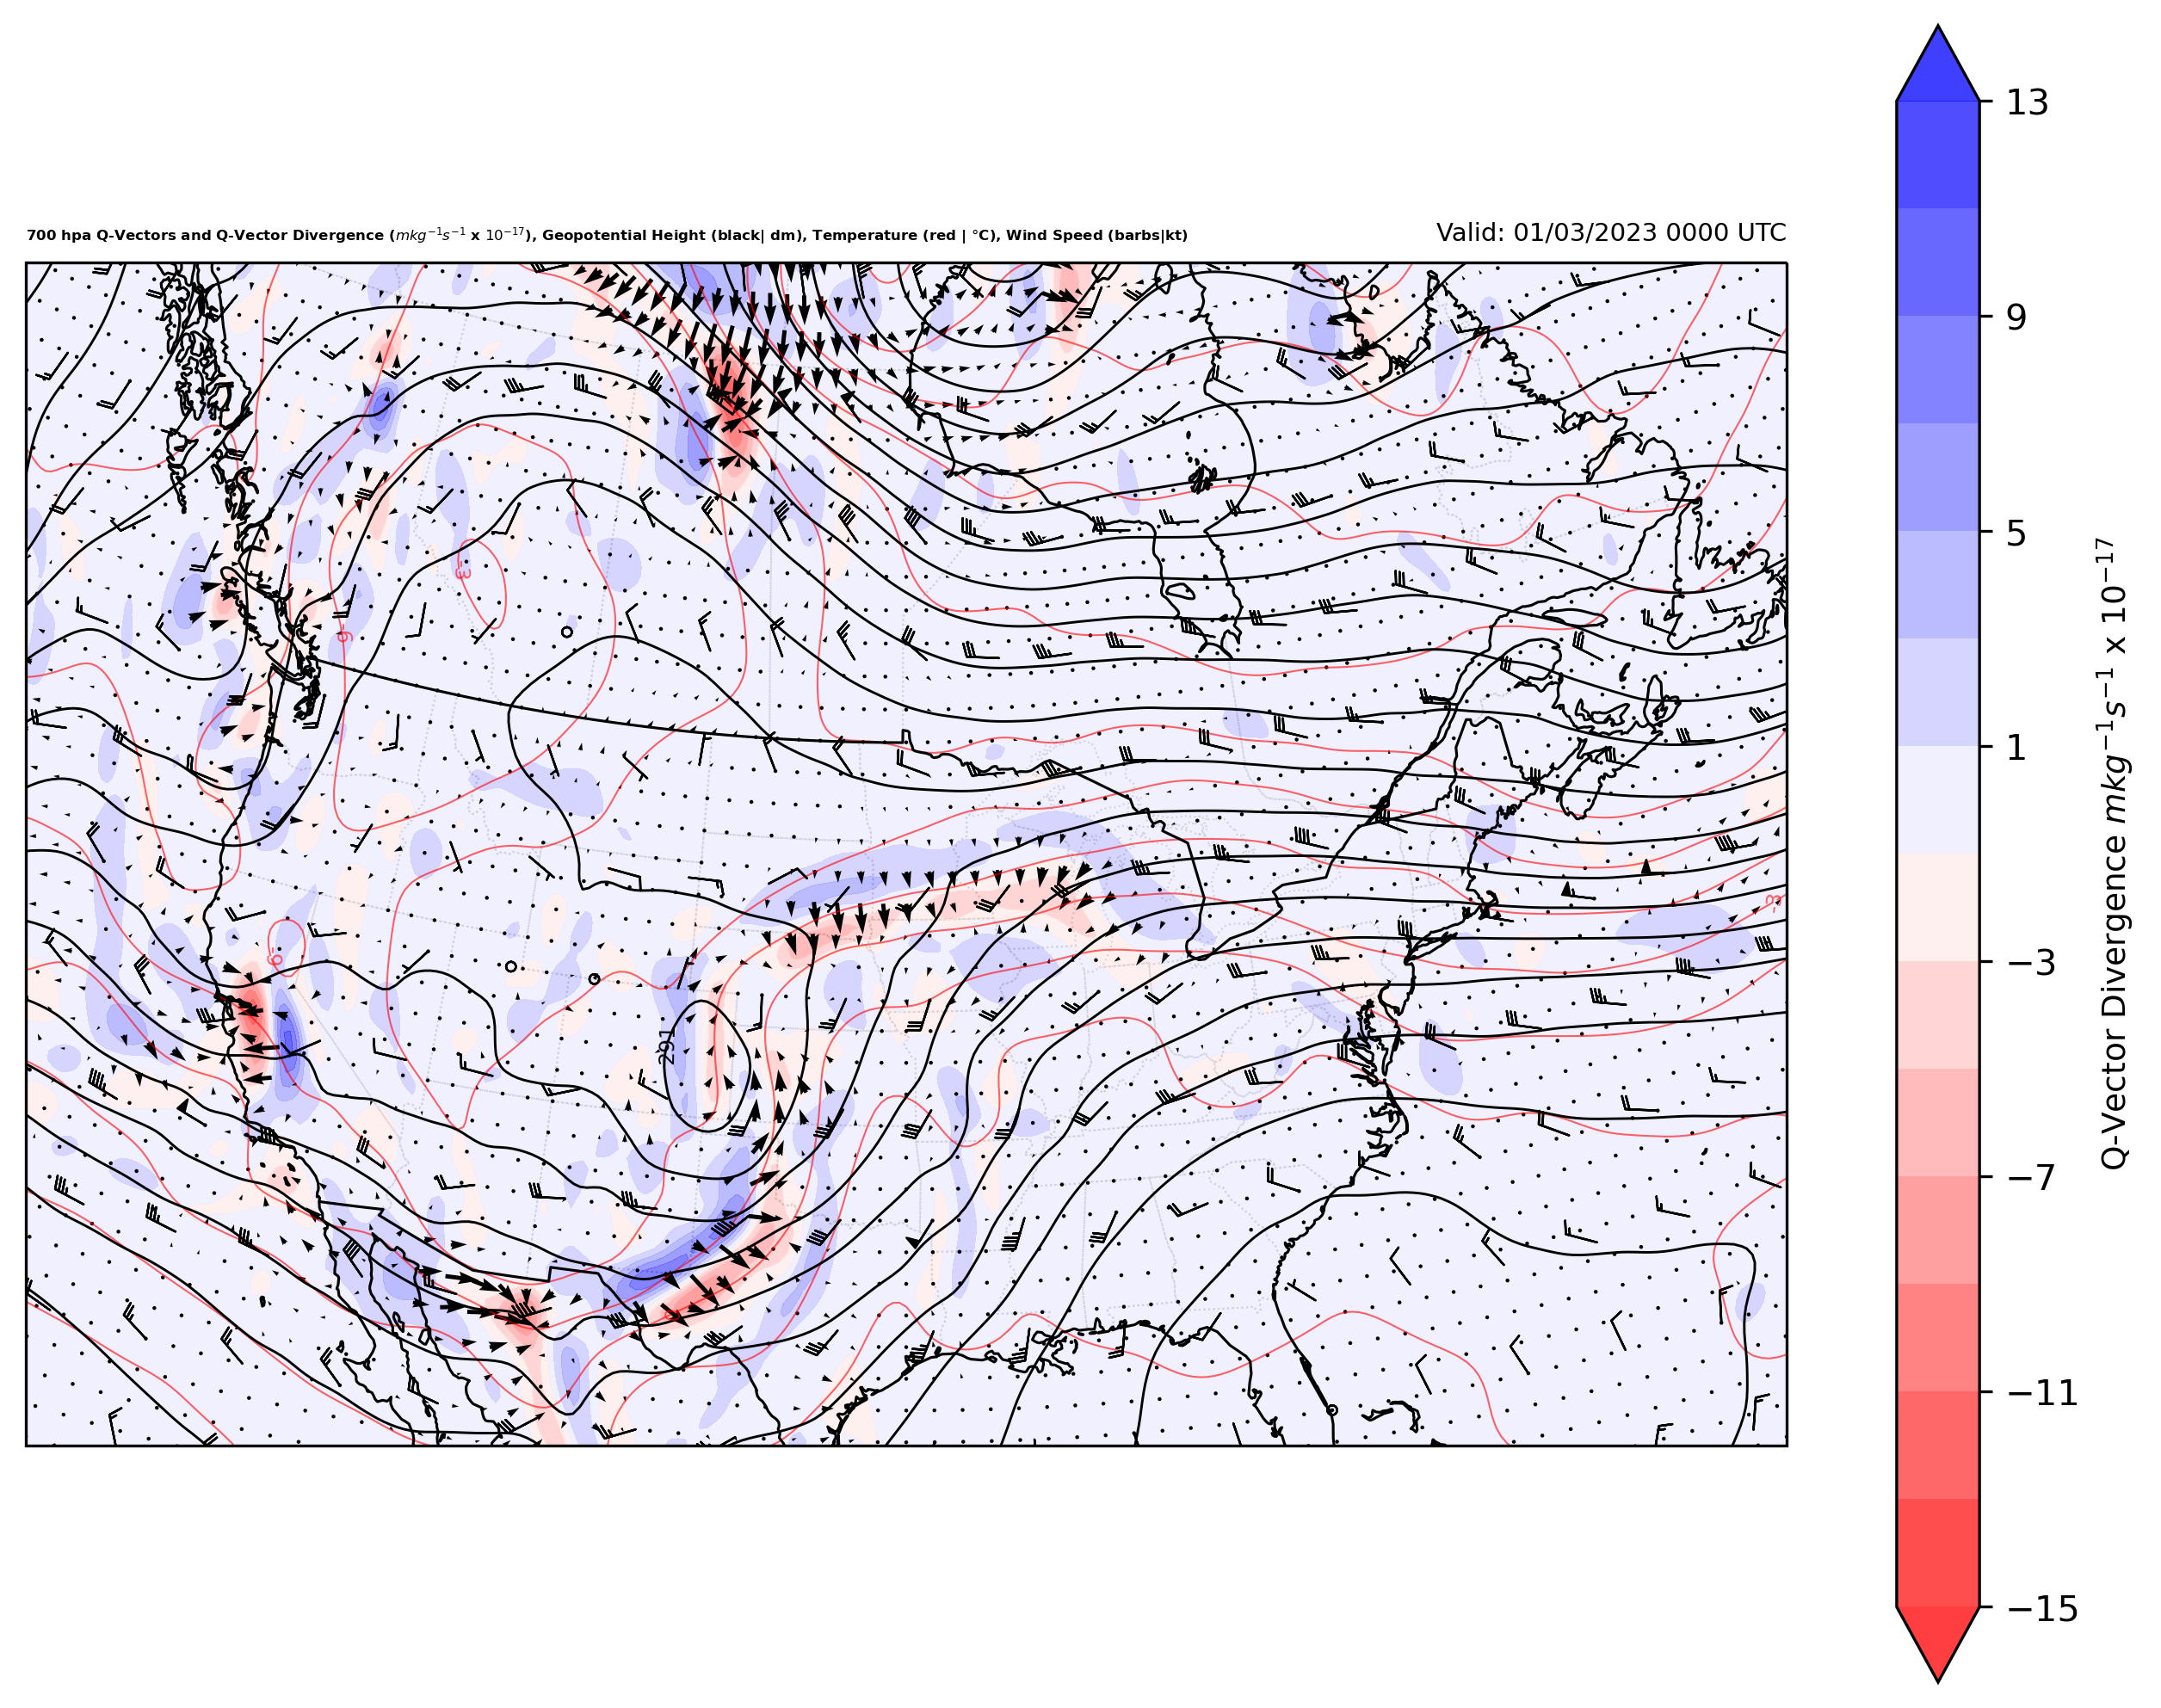

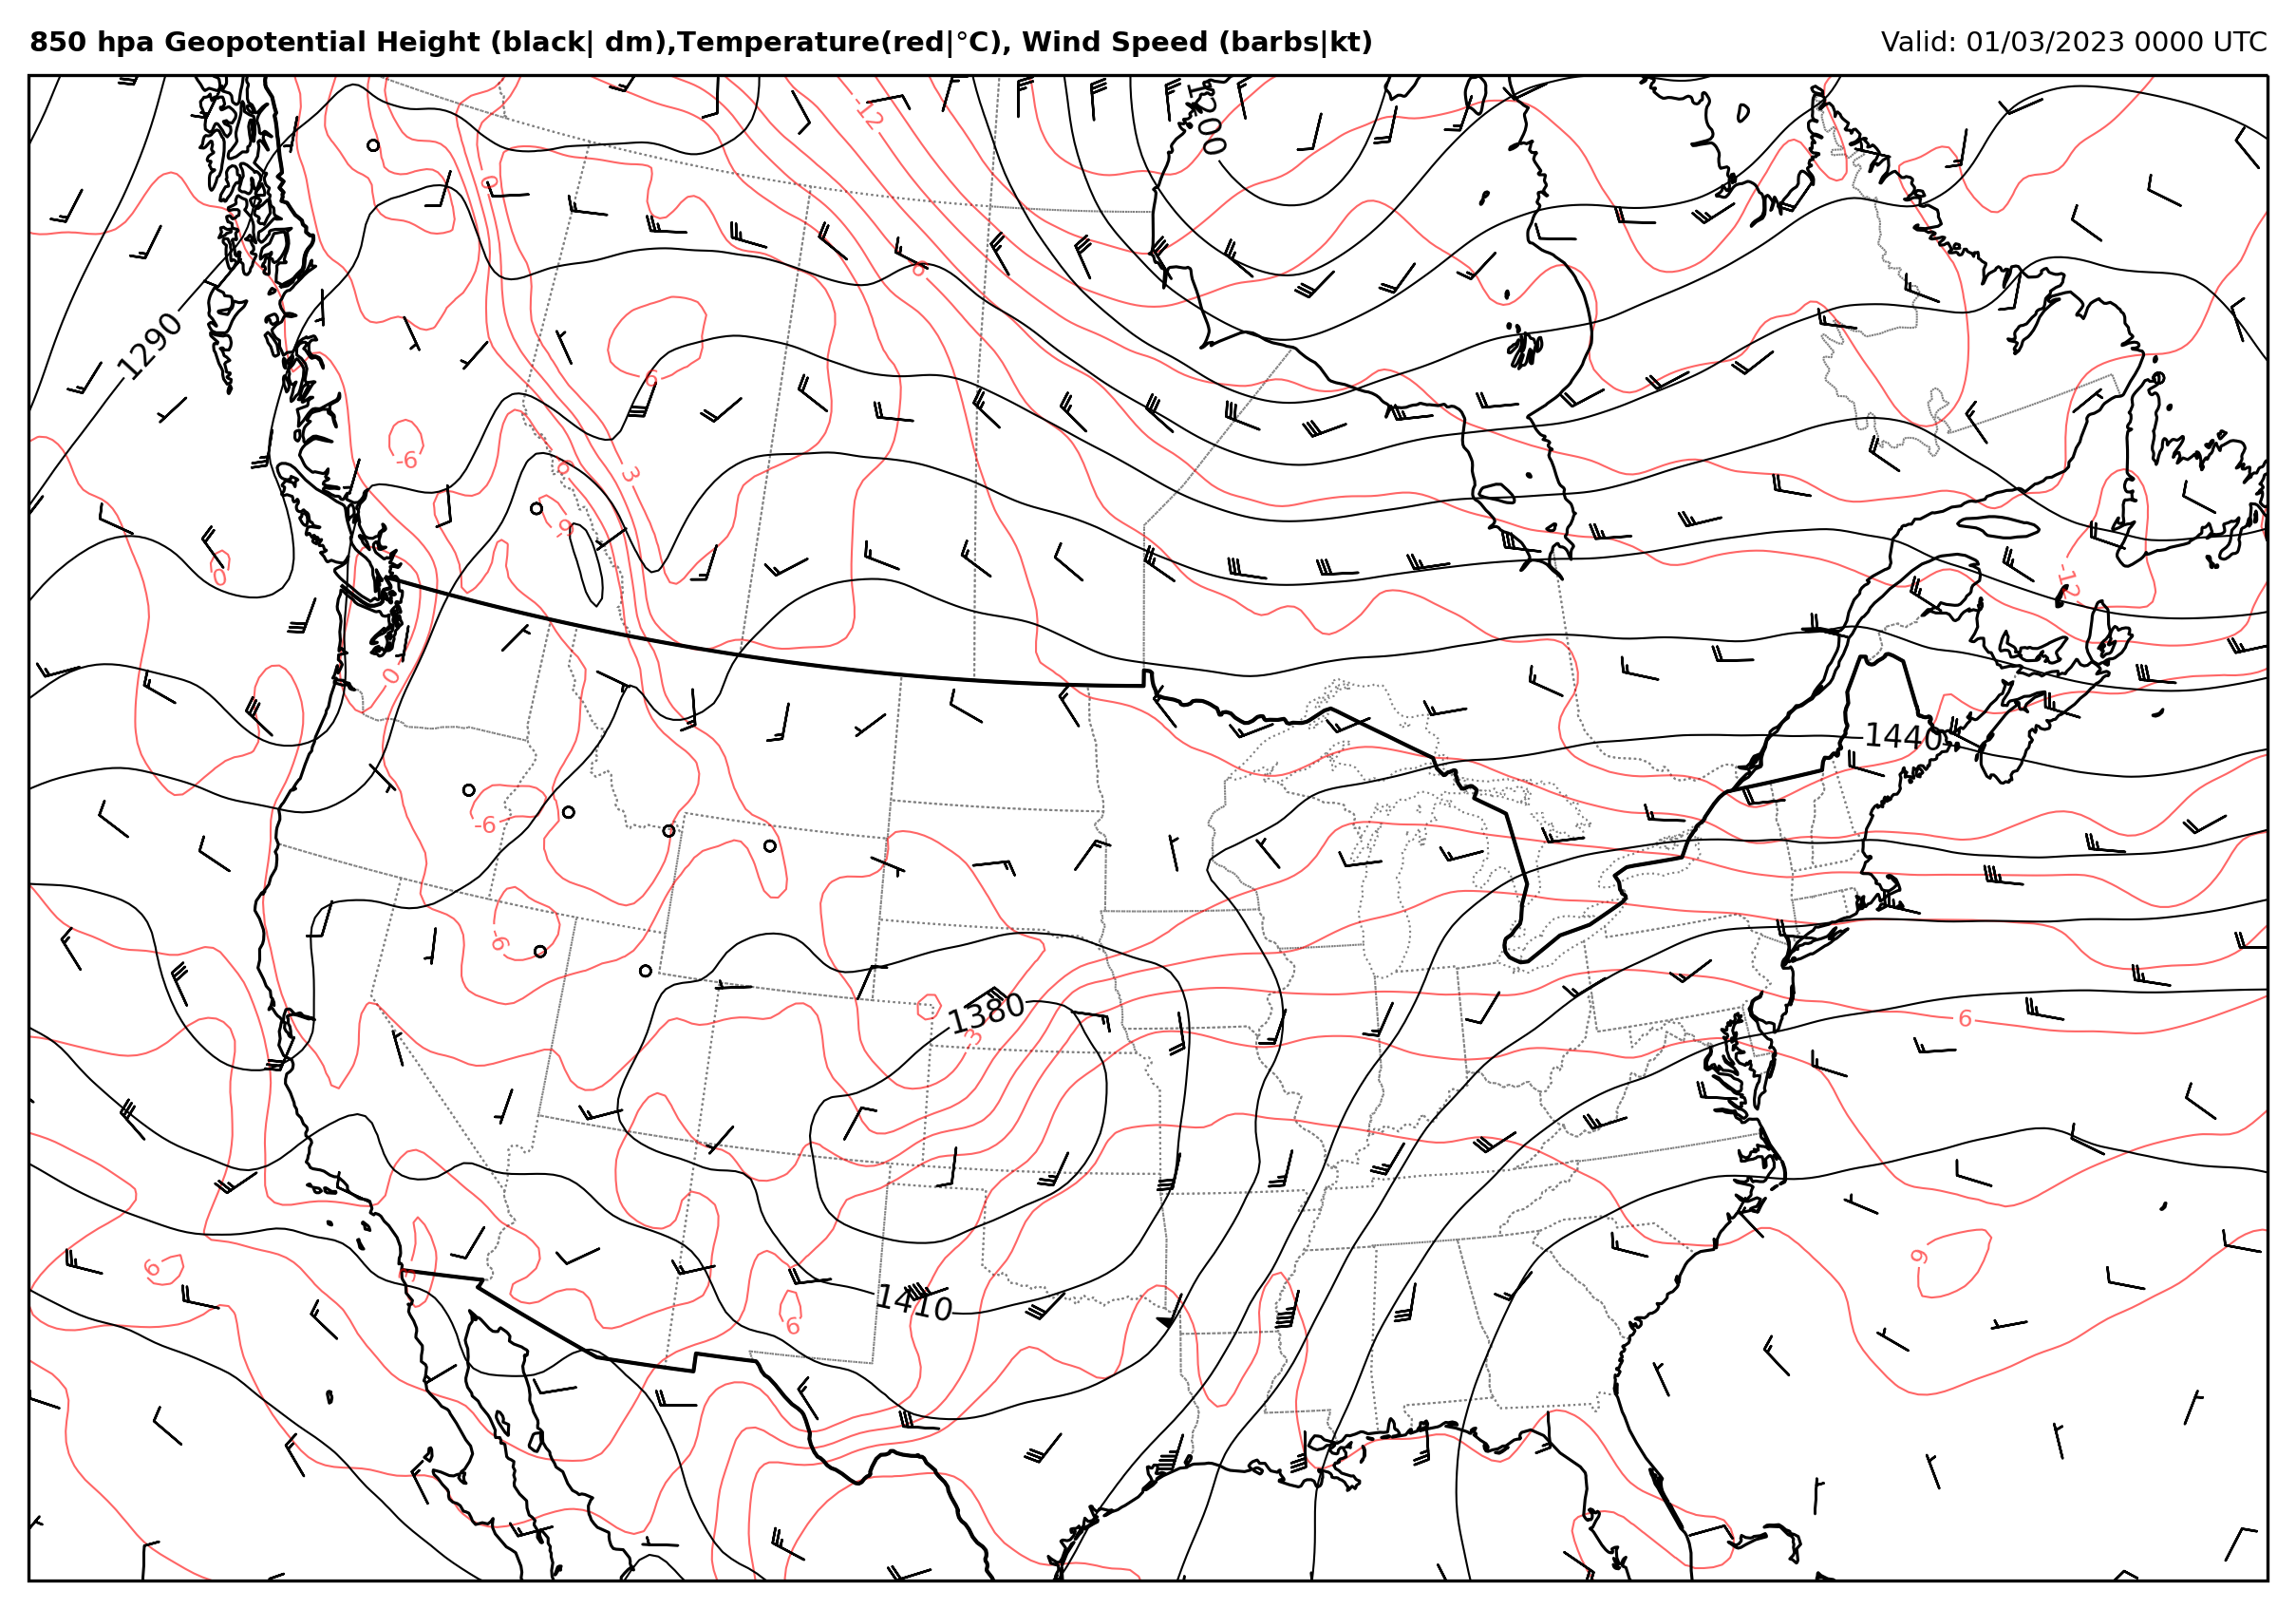

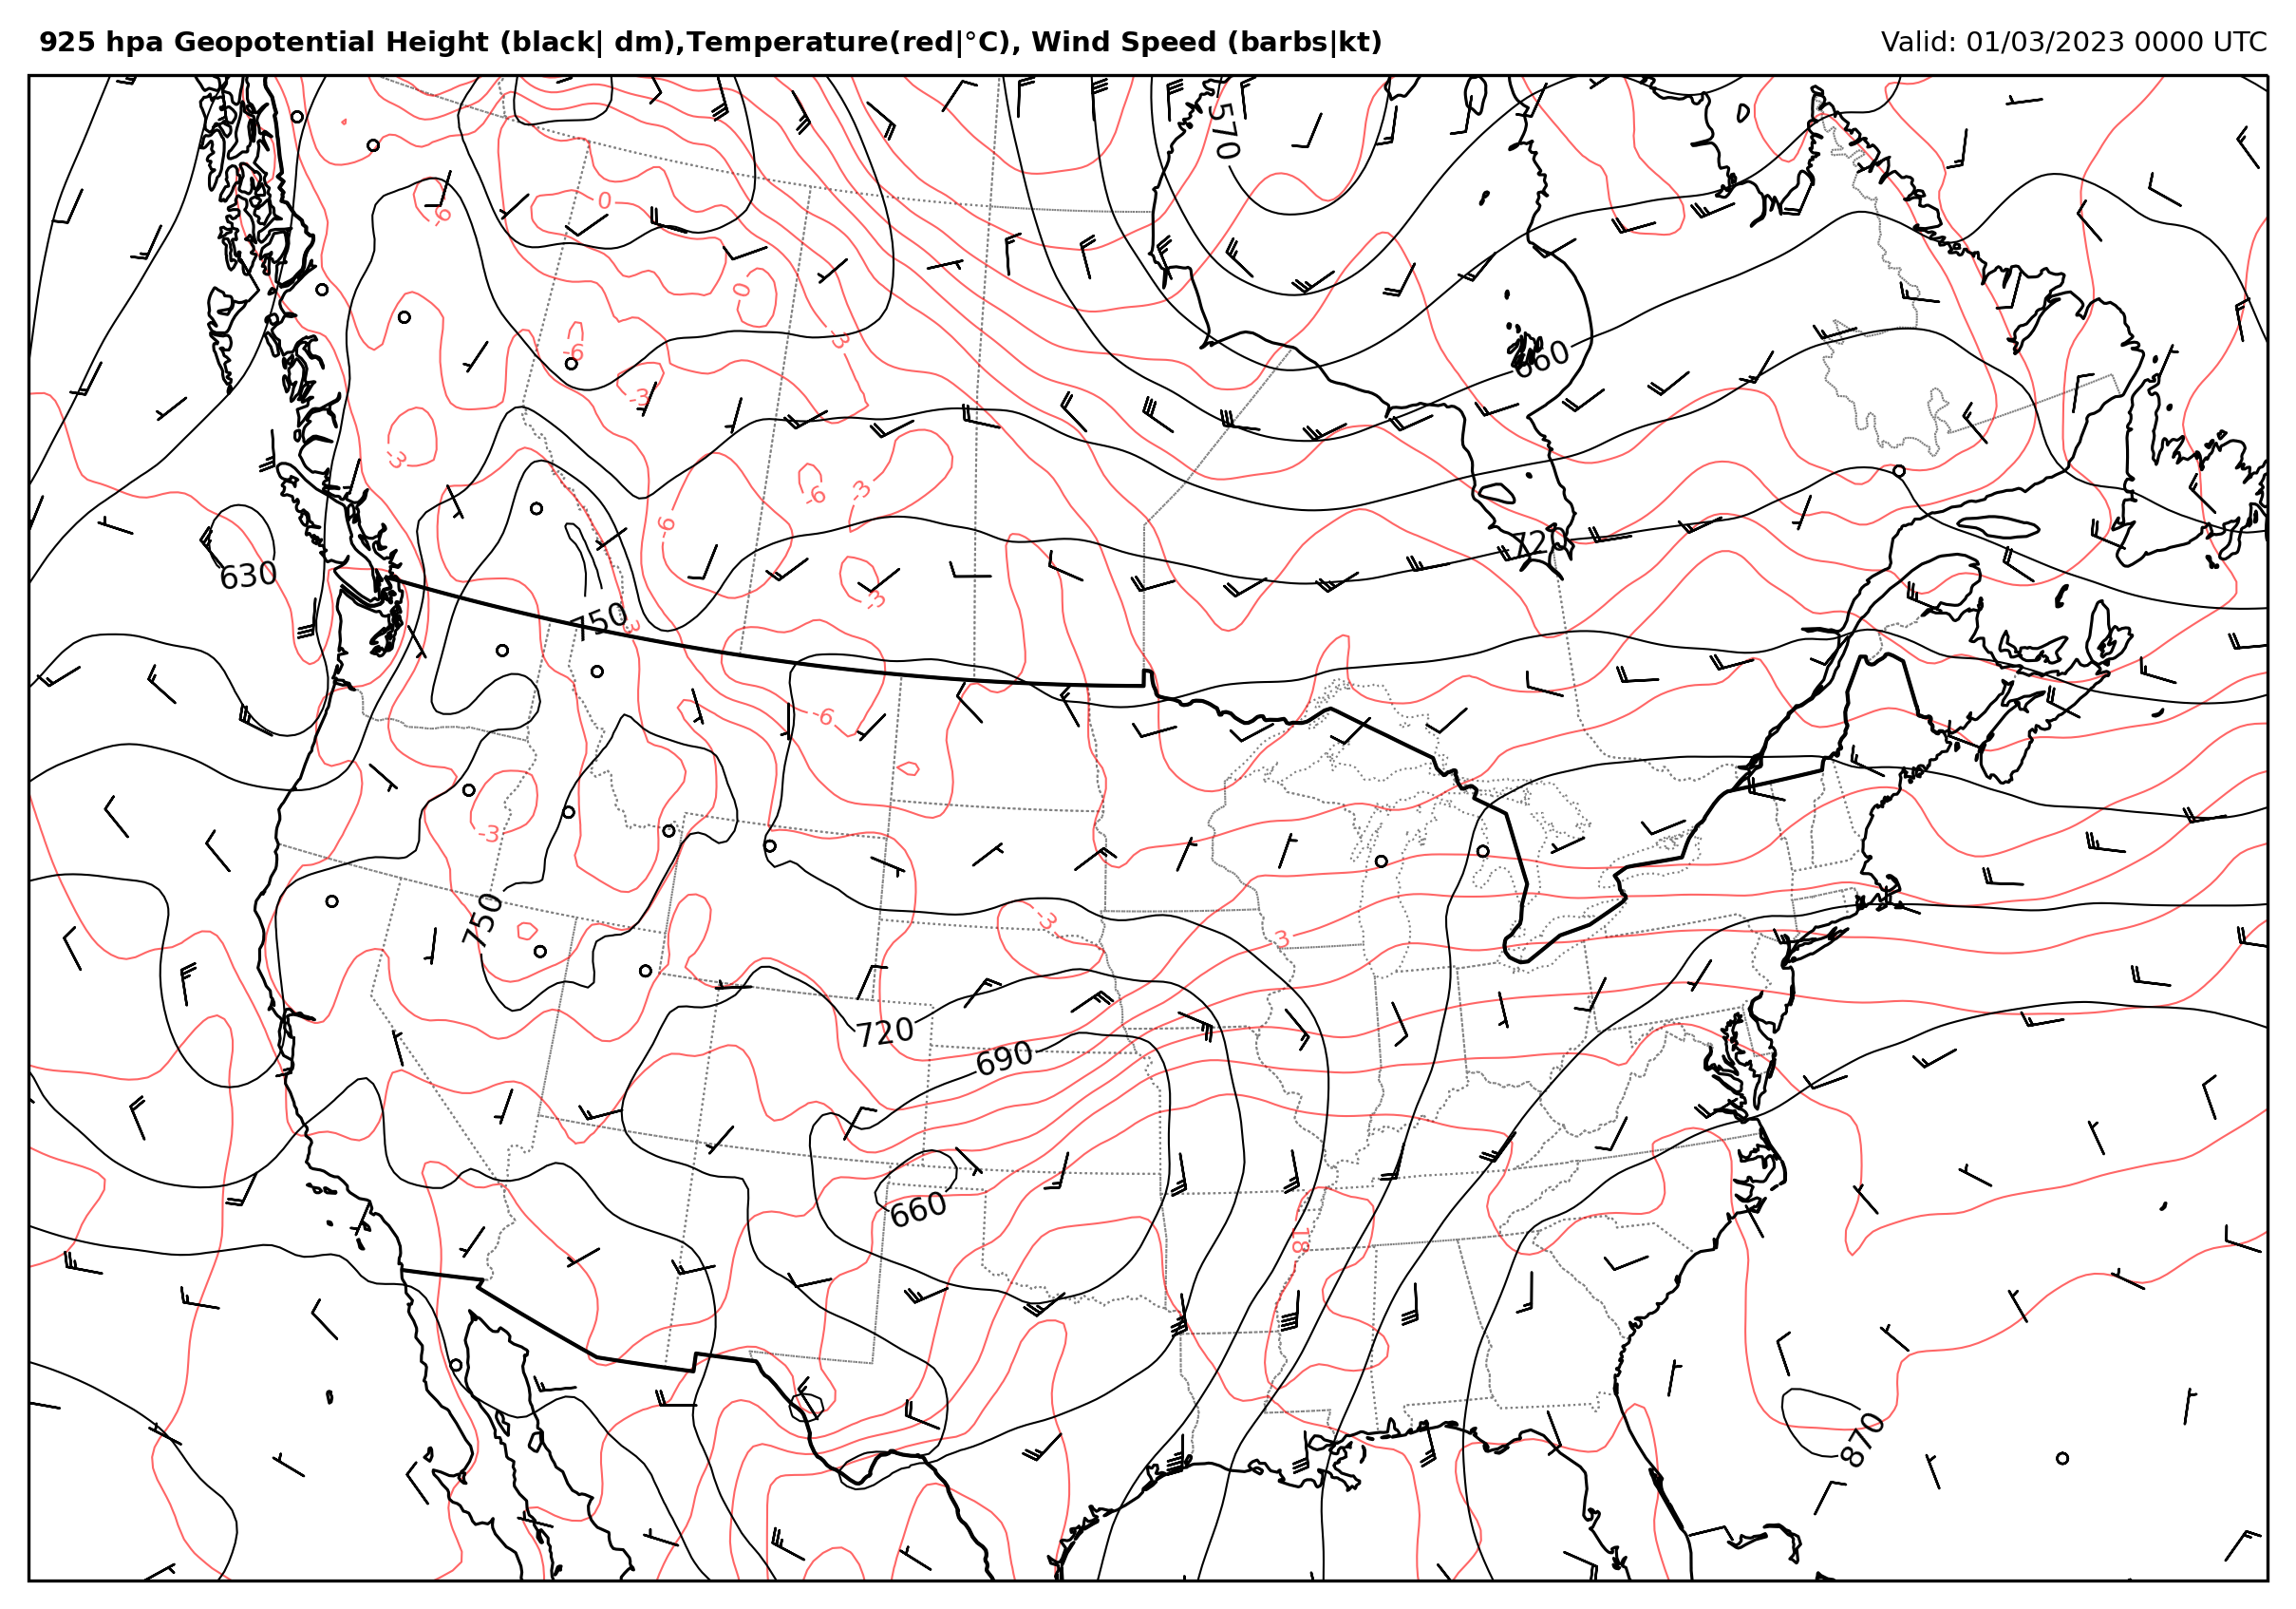

In [13]:
time=datetime(2023,1,3,0)
model_data=process_upper_air_data(time)
plot_700_map(time,model_data)
plot_850_map(time,model_data)
plot_925_map(time,model_data)

In [14]:
def process_K_real_data(time):
    data_location = "/data/AtmSci360/Synp2/Lab_7/"

    file_name = f"{time:%m%d%y_%H}_gfs.grib2"
  
    model_data = xr.open_dataset(f"{data_location}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    levels = [300] * units.kelvin
    Kdata2=calc.isentropic_interpolation_as_dataset(levels, model_data.t, model_data.u, model_data.v, model_data.r, model_data.q)
    return Kdata2

In [15]:
def plot_real_300K(time, Kdata2):
    model_data=Kdata2.sel(isentropic_level=300)
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
 
    fig = plt.figure(figsize=(11.5,7),dpi=300)
    ax=plt.subplot(projection = proj)

    
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
    ax.add_feature(cartopy.feature.BORDERS)
    
    
   
    ax.set_extent((-125, -65, 23, 60))
    
  
    smooth_heights = gaussian_filter(model_data["pressure"].values,2)
    
   
    cont_h = plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,1100,30),linewidths = 0.5,colors='k', transform=crs.PlateCarree())
    
    
    ax.clabel(cont_h, cont_h.levels, fmt=lambda v: format(v, '.0f'),fontsize=8)
    MR=calc.mixing_ratio_from_specific_humidity(model_data.q)
    MR=MR.values*1000
    smooth_MR = gaussian_filter(MR,2)
    

    cont = plt.contourf(model_data["longitude"].values, model_data["latitude"].values,smooth_MR,np.arange(0.4,24,3), cmap='Greens', transform=crs.PlateCarree(), zorder=1, alpha=0.6)
           
    
    cbar = plt.colorbar(cont)
    cbar.set_label(("Mixing Ratio g/kg"), size=10, weight="bold")
    
    wind_slice_x = slice(None, None, 14)
    wind_slice_y = slice(None, None, 14)
    
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6, length=4.25)
    
    
    
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=7, loc="right")         
    plt.title(" 300K, Pressure (black| hpa), Mixing Ratio (filled| g/kg), Wind Speed (barbs|kt)",size=7,weight="bold",loc="left")            
    

Can't create file '/data/AtmSci360/Synp2/Lab_7/041623_12_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 534, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/opt/tljh/user/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 500, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: '/data/AtmSci360/Synp2/Lab_7/041623_12_gfs.grib2.923a8.idx'
Can't read index file '/data/AtmSci360/Synp2/Lab_7/041623_12_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 544, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
  File "/opt/tljh/user/lib/python3.7/genericpath.py", 

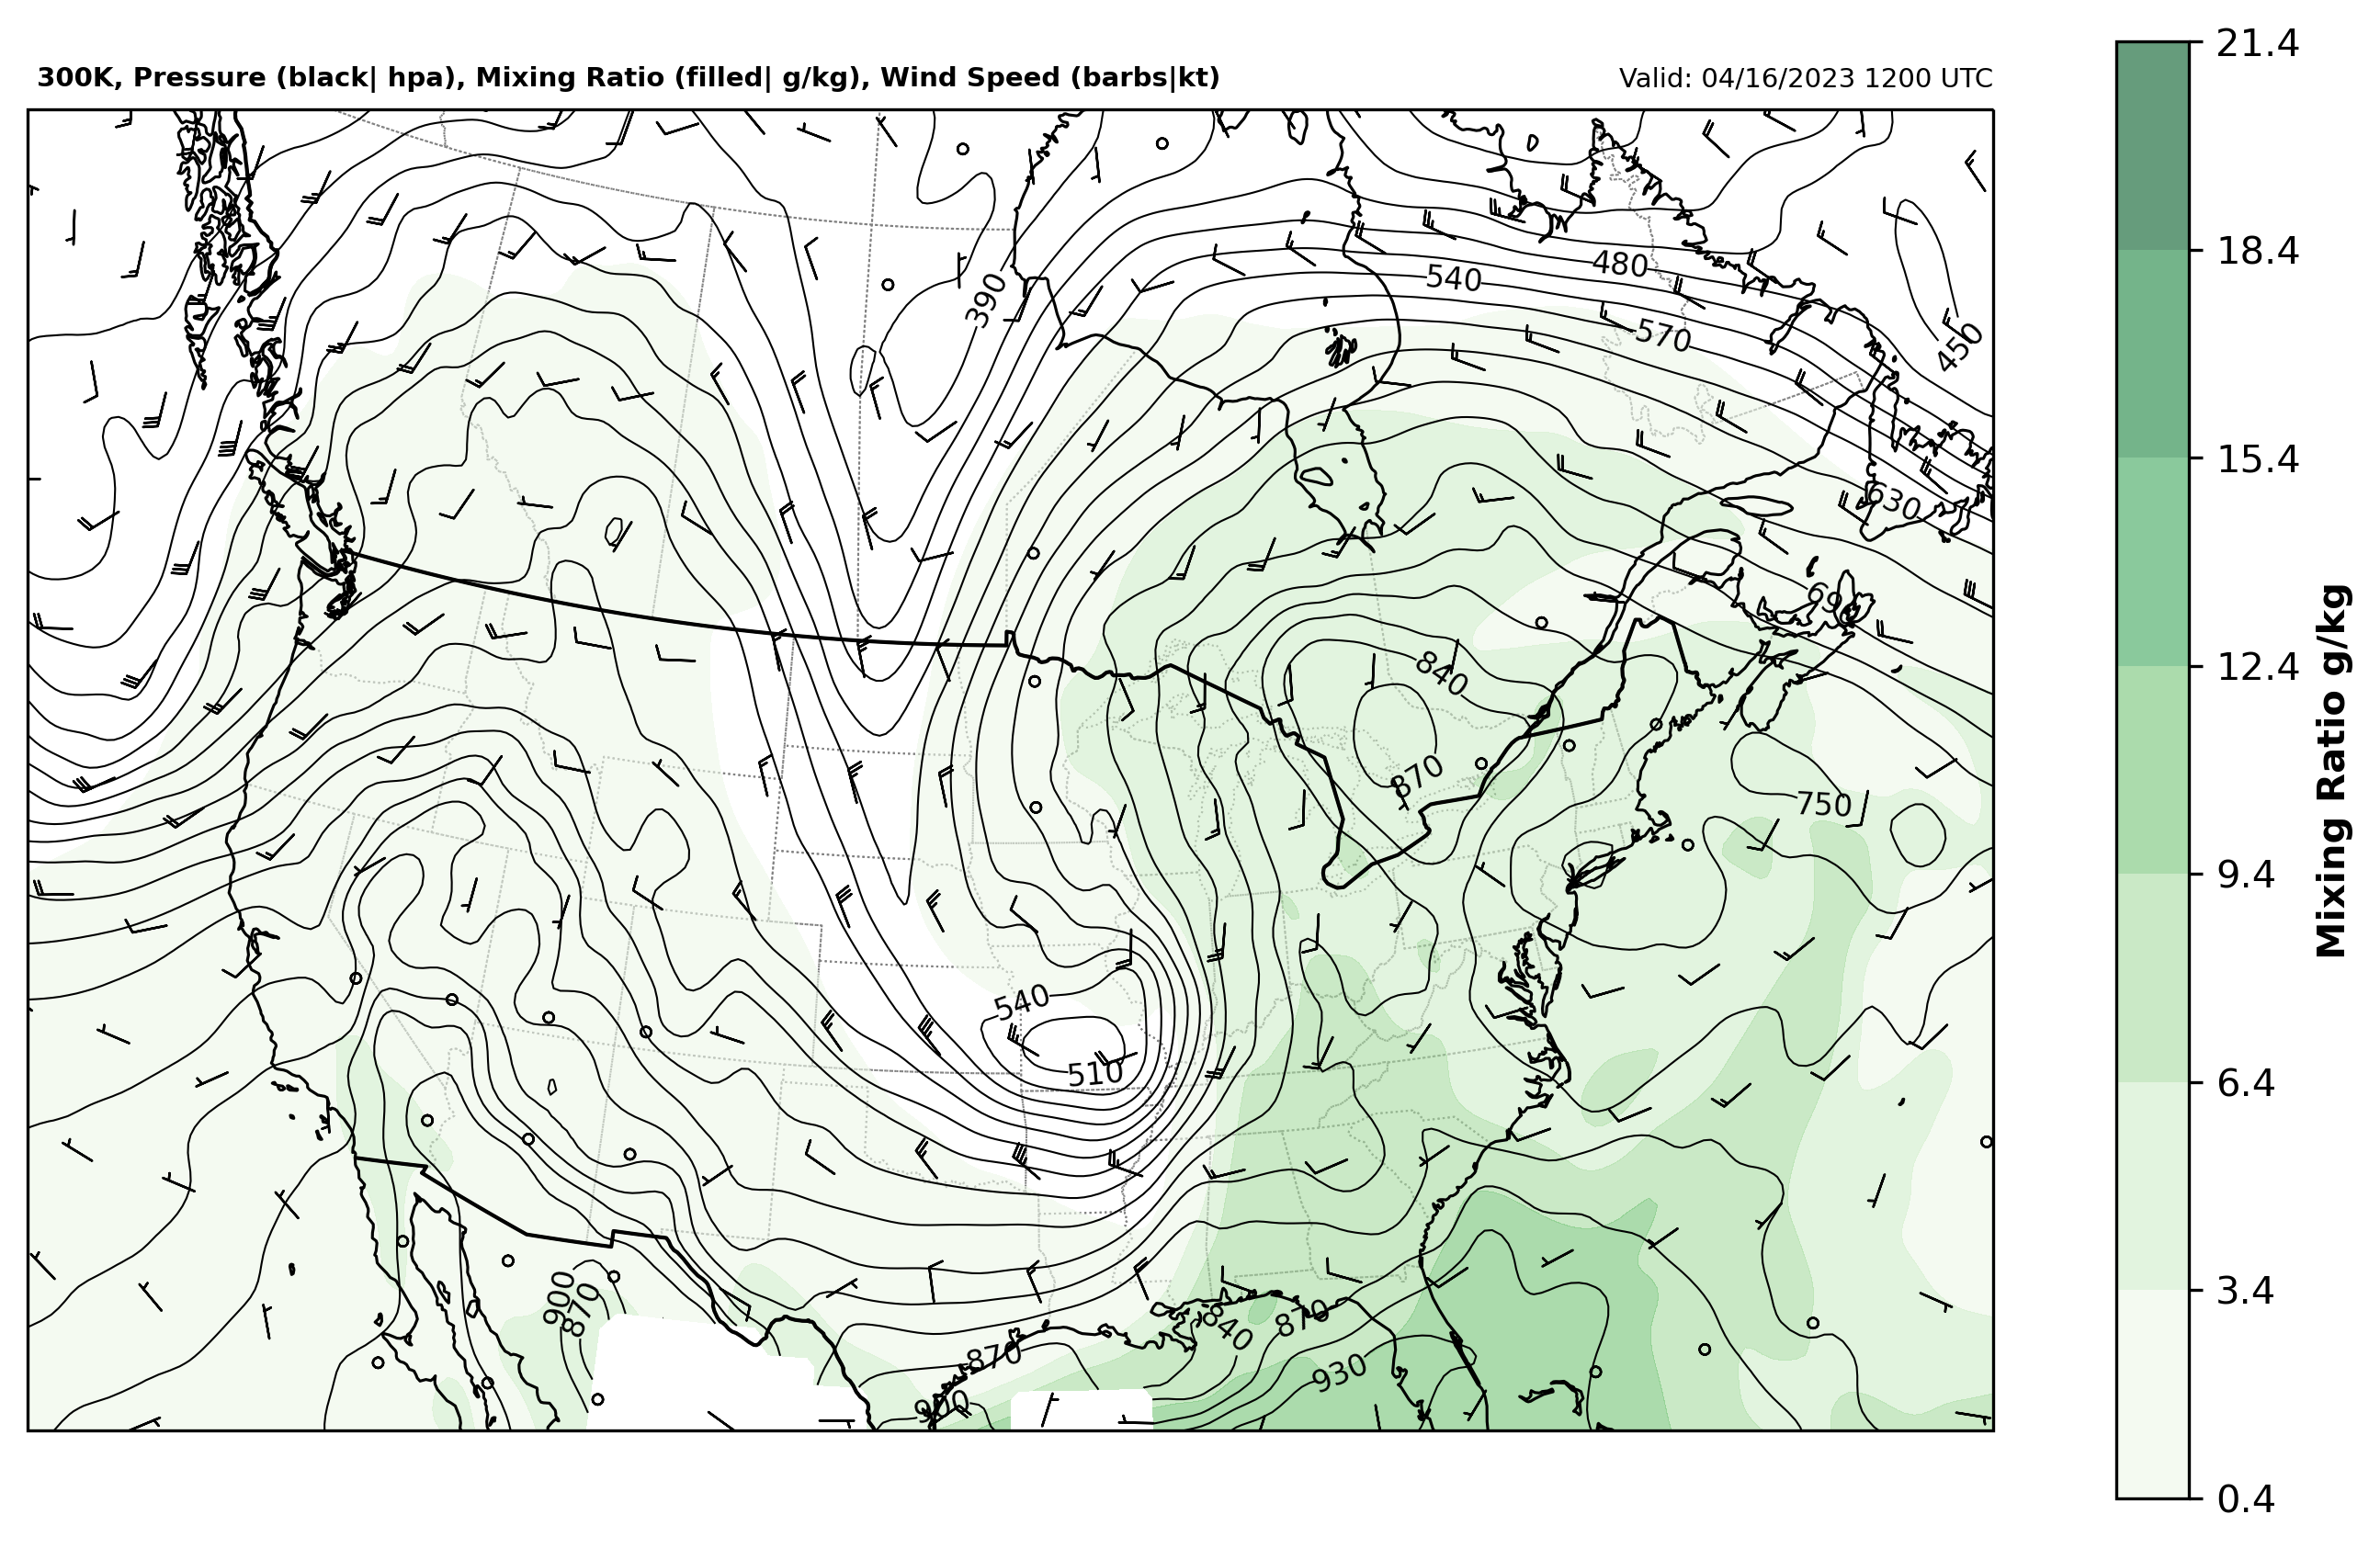

In [20]:
time=datetime(2023,4,16,12)
Kdata2=process_K_real_data(time)
plot_real_300K(time, Kdata2)